The goal of this article is to get to know PyTorch very quickly. Specifically, this article aims to build intuition of how PyTorch works.

# Tensor in PyTorch

A tensor can be initialized by running:

In [1]:
import torch

x = torch.tensor([1,2,3,4])
print(x)

tensor([1, 2, 3, 4])


Indexing can be done a similar fashion as in that of NumPy. For example, if we wanna grab the values of 2 and 3, we can do as follows.

In [2]:
print(x[1:3])

tensor([2, 3])


It is important to note that the PyTorch's datatypes need to be converted to those of NumPy. It is mainly due to the fact that we still need to use matplotlib to plot figures. Generally, we can do the followings.

In [3]:
x.numpy()

array([1, 2, 3, 4])

or

In [4]:
x.detach().numpy()

array([1, 2, 3, 4])

The latter one is more general than the former one. The main difference will be clear once we discuss the autograd feature of PyTorch.

# Linear Regression with PyTorch

Before diving into linear regression, let's start by discussing autograd in PyTorch.

## Autograd

The key operation of 'learning' in machine learning is autograd. Mathematically, it is a fancy way to approximate partial derivation at a certain point. 

Suppose we want to calculate:
$$f(x,y) = 2x^2 + 4y^3$$

$$\frac{\partial  f(x,y)}{\partial x} = 4x$$

$$\frac{\partial  f(x,y)}{\partial y} = 12y^2$$

Then, the partial derivative of the function above at $$(2,3)$$ is $$(4\times (2), 12 \times (3)^2) = (8, 108)$$.

In PyTorch, we can calculate it automatically as shown below.

In [5]:
x = torch.tensor([2.], requires_grad=True)
y = torch.tensor([3.], requires_grad=True)
f_xy = 2*x**2 + 4*y**3

f_xy.backward()
print(x.grad,y.grad)
print(f_xy)

tensor([8.]) tensor([108.])
tensor([116.], grad_fn=<AddBackward0>)


Note that f_xy return the sum of both components. Anyway, x.grad and y.grad are more important. 

In PyTorch, there is another important fact that PyTorch users must know. That is, if we put the backward operation within a loop, e.g., the epoch loop, then the grad will be accumulated.

In [6]:
%config Completer.use_jedi = False

In [7]:
import torch

In [8]:
weights = torch.ones(3, requires_grad=True)

num_epochs = 3;

for i in range(num_epochs):
    output = weights.sum()
    
    output.backward()
    print(weights.grad)

tensor([1., 1., 1.])
tensor([2., 2., 2.])
tensor([3., 3., 3.])


See that the grad is accumulated. 

## Into the linear regression 

Suppose we want to estimate a noisy data $y$, e.g.,:

$$y = x + n,$$

where $n$ is a noise. 

In [9]:
num_samples = 100
x = torch.linspace(1,10,num_samples).view(num_samples,1)
y = x + torch.randn(num_samples,1)

In [10]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'y')

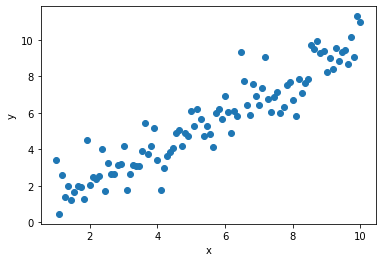

In [11]:
plt.plot(x,y,'o')
plt.xlabel('x')
plt.ylabel('y')

Suppose we want to estimate it with a linear model as follows:
$$\hat{y} = w x + b,$$
where $w$ and $b$ are parameters to be estimated.

The typical approach to create an ML model is:
1. define a model class that has at least a constructor and a predictor,
2. define a loss function and an optimizer, 
3. training phase, and
4. validation phase



### 1. Define a class

Let's create a NN with an input size and an output size.

In [12]:
import torch.nn as nn # let's use a NN
class LinReg(nn.Module): # there are many useful methods from nn.Module
    
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(in_features=input_size,out_features=output_size)
        
    def forward(self,x):
        prediction = self.linear(x)
        return prediction
    

In [13]:
model = LinReg(1,1)

In [14]:
list(model.parameters())

[Parameter containing:
 tensor([[0.8907]], requires_grad=True),
 Parameter containing:
 tensor([-0.9754], requires_grad=True)]

In [15]:
print(model.linear.weight,model.linear.bias)

Parameter containing:
tensor([[0.8907]], requires_grad=True) Parameter containing:
tensor([-0.9754], requires_grad=True)


Note: when we instantiate a model, we will be given a randomly initialized values of the parameters, i.e., weight and bias.

## 2. Loss function

We'll choose the mean-squared error criterion and the SGD optimizer.

In [16]:
loss_fun = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-3)

## 3. Training

The following is the typical flow:

forward operation (run predictor) $\rightarrow$ obtain error or loss $\rightarrow$ calculate the gradient (backward operation) $\rightarrow$ update parameters $\rightarrow$ repeat

In [17]:
num_epochs = 100
losses_array = []

for i in range(num_epochs):
    y_pred = model.forward(x) # batch size is the whole samples
    loss = loss_fun(y_pred,y) # y is from dataset
    losses_array.append(loss.detach().numpy())
    
    optimizer.zero_grad() # this is necessary as the grad is accumulated. Will be needed for RNN
    loss.backward()
    optimizer.step() # updates the parameters according to SGD
    
    print("epoch: ", i, " loss: ", loss.item())

    

epoch:  0  loss:  3.3694205284118652
epoch:  1  loss:  3.048598289489746
epoch:  2  loss:  2.7745981216430664
epoch:  3  loss:  2.540583848953247
epoch:  4  loss:  2.3407142162323
epoch:  5  loss:  2.1700026988983154
epoch:  6  loss:  2.0241897106170654
epoch:  7  loss:  1.8996398448944092
epoch:  8  loss:  1.7932465076446533
epoch:  9  loss:  1.7023577690124512
epoch:  10  loss:  1.624709963798523
epoch:  11  loss:  1.5583690404891968
epoch:  12  loss:  1.5016826391220093
epoch:  13  loss:  1.4532417058944702
epoch:  14  loss:  1.4118413925170898
epoch:  15  loss:  1.3764532804489136
epoch:  16  loss:  1.3461991548538208
epoch:  17  loss:  1.3203297853469849
epoch:  18  loss:  1.2982045412063599
epoch:  19  loss:  1.2792768478393555
epoch:  20  loss:  1.2630795240402222
epoch:  21  loss:  1.249213457107544
epoch:  22  loss:  1.2373383045196533
epoch:  23  loss:  1.2271634340286255
epoch:  24  loss:  1.2184405326843262
epoch:  25  loss:  1.210957646369934
epoch:  26  loss:  1.204533219

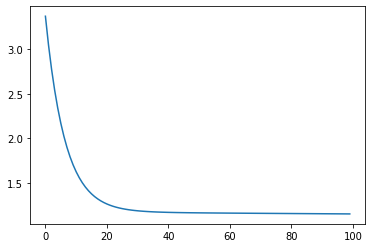

In [18]:
import numpy as np
plt.plot(np.arange(num_epochs),losses_array)

## 4. Validation

Let's check the updated parameters

In [19]:
list(model.parameters())

[Parameter containing:
 tensor([[1.1214]], requires_grad=True),
 Parameter containing:
 tensor([-0.8925], requires_grad=True)]

These are pretty good as the optimal parameters are $w$ = 1 and $b=0$. Anyway, let's plot the results.

In [20]:
y_pred = model.forward(x)

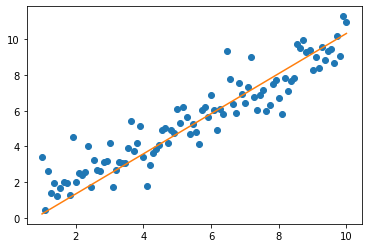

In [21]:
plt.plot(x,y,'o',x,y_pred.detach().numpy());

This is still a warm-up. We'll kick it up a notch in the next notebook.